##Libraries

In [8]:
import os, warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from tqdm.notebook import tqdm
from scipy.stats import kstest, t
OMP_NUM_THREADS=1

## Loading data

- The data comes from [investing.com](https://ng.investing.com/indices/nse-all-share-historical-data)

In [9]:
nse = pd.read_csv('NSE.csv')

## basic EDA

In [10]:
nse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2722 non-null   object
 1   Price     2722 non-null   object
 2   Open      2722 non-null   object
 3   High      2722 non-null   object
 4   Low       2722 non-null   object
 5   Vol.      1901 non-null   object
 6   Change %  2722 non-null   object
dtypes: object(7)
memory usage: 149.0+ KB


In [11]:
# variables types
nse.Date = pd.to_datetime(nse.Date)
nse.Price = nse.Price.str.replace(',', '').astype(float)
nse.Open = nse.Open.str.replace(',', '').astype(float)
nse.High = nse.High.str.replace(',', '').astype(float)
nse.Low = nse.Low.str.replace(',', '').astype(float)
nse["Vol."]= nse["Vol."].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').str.replace('-', '0').astype(float)
nse["Change %"] = nse["Change %"].str.replace('%', '').astype(float)
nse.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-30,103149.35,102133.30,103242.01,102122.69,641080000.0,0.99
1,2024-12-27,102133.30,102188.85,102406.95,102033.63,443720000.0,-0.05
2,2024-12-24,102186.03,101365.06,102206.85,101055.65,397520000.0,0.82
3,2024-12-23,101356.15,101114.25,101488.10,101042.57,503180000.0,0.22
4,2024-12-20,101129.09,101247.53,101350.47,100796.84,513560000.0,-0.12


<Axes: title={'center': 'Nigeria SE All-Share Index'}, xlabel='Date'>

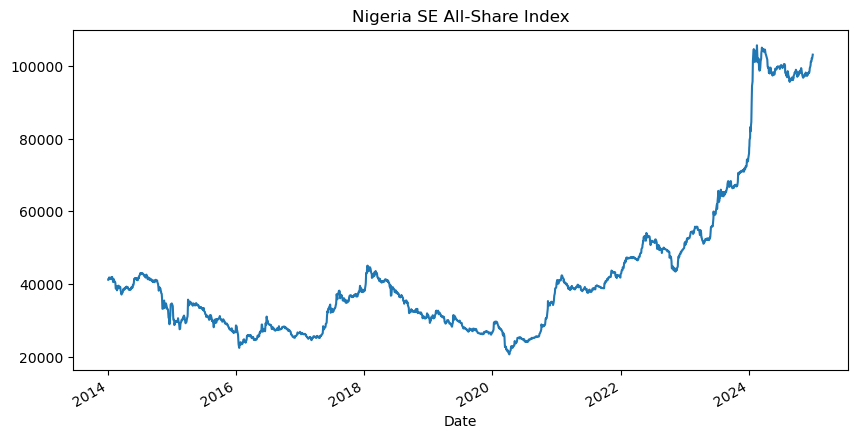

In [12]:
nse.sort_values('Date').set_index('Date').Price.plot(kind='line', title='Nigeria SE All-Share Index', figsize=(10, 5))

In [49]:
n_days = 90
conf_level = 0.99

<Axes: title={'center': 'NSE Index'}, xlabel='Date'>

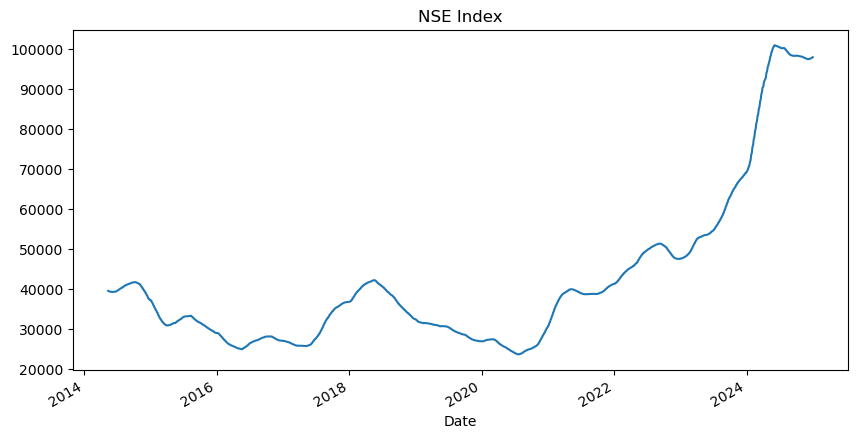

In [50]:
nse.sort_values("Date").set_index("Date")['Price'].rolling(window=n_days).mean().plot(kind='line', title='NSE Index', figsize=(10, 5))

<Axes: xlabel='Price', ylabel='Density'>

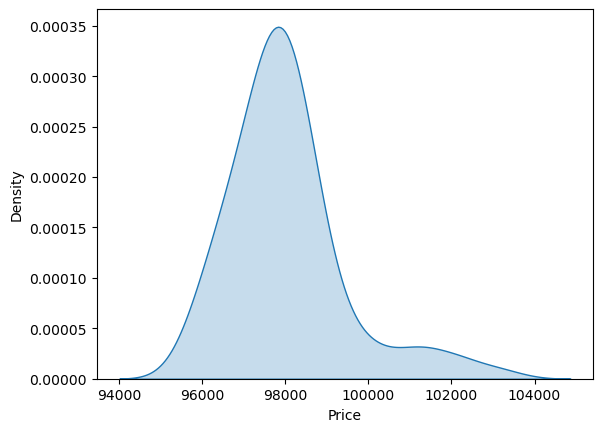

In [51]:
sns.kdeplot(nse["Price"].head(n_days), fill=True)

## Test if the data follows a Student distribution

In [52]:
# Extract the prices
prices = nse["Price"].head(n_days)

# Fit the data to a Student's t-distribution and get the parameters
params = t.fit(prices)

# Perform the Kolmogorov-Smirnov test
D, p_value = kstest(prices, 't', args=params)

print('KS Statistic: %.3f' % D)
print('p-value: %.3f' % p_value)

if p_value < 0.05:
    print('The null hypothesis that the data follows a Student\'s t-distribution is rejected.')
else:
    print('The null hypothesis that the data follows a Student\'s t-distribution is not rejected.')

KS Statistic: 0.138
p-value: 0.060
The null hypothesis that the data follows a Student's t-distribution is not rejected.


## Simple Confidence Interval

In [62]:
# Fit the data to a Student's t-distribution and get the parameters
params = t.fit(prices)

# Number of synthetic samples to generate
n_samples = 10000

# Generate synthetic samples for the next day's price
synthetic_samples = t.rvs(params[0], params[1], params[2], size=n_samples)

# Calculate the 95% confidence interval for the next day's price
conf_interval = np.percentile(synthetic_samples, [round(((1-conf_level)/2)*100, 1), (conf_level + (1-conf_level)/2)*100])

print('95% Confidence Interval for the next day\'s price:')
print(conf_interval)

95% Confidence Interval for the next day's price:
[ 94438.97413816 101494.99631846]


## One-tailed test to see if the prices will go above 100000

In [54]:
# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(nse["Price"].head(n_days), 100000, alternative="greater")

# check if the price is greater than 100000
if p_value < 0.05:
    print('The null hypothesis that the price is greater than 100,000 is rejected.')
else:
    print('The null hypothesis that the price is greater than 100,000 is not rejected.')

The null hypothesis that the price is greater than 100,000 is not rejected.


## Monte Carlo Simulation

In [55]:
# Fit the data to a Student's t-distribution and get the parameters
params = t.fit(prices)

# Monte Carlo simulation parameters
n_simulations = 10000000
intervals_bounds = [0, 100000, 102000]

# Initialize counters
n_times_price_falls_below_100000 = 0
n_times_price_falls_between_100000_102000 = 0
n_times_price_falls_above_102000 = 0

# Perform Monte Carlo simulation
for i in tqdm(range(n_simulations)):
    # Generate synthetic samples for the next day's price using the Student's t-distribution
    simulated_price = t.rvs(params[0], params[1], params[2], size=n_days)
    
    # Check which interval the minimum simulated price falls into
    min_price = simulated_price.min()
    if min_price < intervals_bounds[1]:
        n_times_price_falls_below_100000 += 1
    elif min_price < intervals_bounds[2]:
        n_times_price_falls_between_100000_102000 += 1
    else:
        n_times_price_falls_above_102000 += 1


  0%|          | 0/10000000 [00:00<?, ?it/s]

In [63]:
# Calculate probabilities
prob_below_100000 = n_times_price_falls_below_100000 / n_simulations
prob_between_100000_102000 = n_times_price_falls_between_100000_102000 / n_simulations
prob_above_102000 = n_times_price_falls_above_102000 / n_simulations


pd.DataFrame({
    'Interval': ['Below 100,000', 'Between 100,000 and 102,000', 'Above 102,000'],
    'Probability': [round(x*100, 2) for x in [prob_below_100000, prob_between_100000_102000, prob_above_102000]]
})

,Interval,Probability
0,"Below 100,000",100.0
1,"Between 100,000 and 102,000",0.0
2,"Above 102,000",0.0
